In [147]:
%matplotlib inline

import glob
import os
import sys
import time
import numpy as np
import pandas as pd
import json
from tqdm import tqdm
from pandas.io.json import json_normalize

import matplotlib.pyplot as plt

In [7]:
def get_dfs():
    show_data = []
    user_data = []

    for i,fname in tqdm(enumerate(fnames),total=len(fnames)):
    # for fname in tqdm(fnames[:3000]):
    #     if i > 3000: break
        try:
            js = json.load(open(fname))
        except:
            pass
        username = fname.rsplit("/",1)[1].split(".",1)[0]
        gender = js["overview"].get("gender",None)
        join_date = js["overview"].get("join_date",None)
        birthday = js["overview"].get("birthday",None)
        last_online = js["overview"].get("last_online",None)
        dropped = js["dropped"]
        completed = js["completed"]
        user_data.append(
            dict(
                username=username,
                gender=gender,
                join_date=join_date,
                birthday=birthday,
                last_online=last_online,
                ndropped=len(dropped),
                ncompleted=len(completed),
            )
        )
        for d in dropped:
            d["username"] = username
            d["completed"] = False
            show_data.append(d)
        for d in completed:
            d["username"] = username
            d["completed"] = True
            show_data.append(d)

    df_users = pd.DataFrame(user_data)
    df_shows = pd.DataFrame(show_data)


    del show_data
    del user_data

    df_users.head()
    df_shows.head()
    return df_users, df_shows


In [9]:
def slim_and_dump_dfs(df_users,df_shows):

    if "username" in df_shows.keys():
        df_users["uid"] = df_users.username.astype("category")
        df_shows["uid"] = df_shows.username.astype("category",categories=df_users.uid.cat.categories).cat.codes.astype(int)
        df_shows = df_shows.drop(["username"],axis=1)
    # df_shows["uid"] = df_shows.username.astype("category",categories=df_users.uid.cat.categories)

    # df_shows = df_shows.drop(["username"],axis=1)

    df_shows["title"] = df_shows["title"].astype("category")
    df_shows["kind"] = df_shows["kind"].astype("category")
    df_shows["country"] = df_shows["country"].astype("category")

    print "dumping shapes {} and {}".format(df_users.shape,df_shows.shape)
    t0 = time.time()
    df_users.to_pickle("df_users.pkl.bz2")
    df_shows.to_pickle("df_shows.pkl.bz2")
    # df_shows.to_feather("test.pkl.ft")
    print "dumped in {:.2f}sec".format(time.time()-t0)
    return df_users, df_shows
    # df_shows.to_hdf("test.h5","shows")

    # print df_shows.uid

In [10]:
# df_shows.uid.dtype

if not os.path.exists("df_users.pkl.bz2"):
    df_users, df_shows = get_dfs()
    df_users, df_shows = slim_and_dump_dfs(df_users, df_shows)
else:
    print "loading"
    t0 = time.time()
    df_users = pd.read_pickle("df_users.pkl.bz2")
    df_shows = pd.read_pickle("df_shows.pkl.bz2")
    print "loaded in {:.2f}sec".format(time.time()-t0)
    # df_shows = pd.read_hdf("test.h5")
    # df_shows.uid.dtype

loading
loaded in 12.27sec


In [12]:
df_shows.head()

,completed,country,ep_seen,ep_total,kind,score,tid,title,year,uid,num_users,score_mean,score_median,user_score_mean
0,False,Japan,5,10,Drama,5.0,296,Abarenbo Mama,2007,3530,37,1.878378,0.0,2.722222
1,False,Japan,1,11,Drama,5.0,185,Celeb to Binbo Taro,2008,3530,55,2.190909,0.0,2.722222
2,False,South Korea,0,16,Drama,0.0,1701,Dream High 2,2012,3530,641,2.271451,1.0,2.722222
3,False,Japan,3,10,Drama,5.0,23,Kimi wa Petto,2003,3530,178,2.078652,0.0,2.722222
4,False,South Korea,2,16,Drama,3.5,31,My Girlfriend is a Gumiho,2010,3530,646,2.133901,0.0,2.722222


In [11]:
df_users.head()

,birthday,gender,join_date,last_online,ncompleted,ndropped,username,uid
0,October 15,Female,"January 3, 2012","Jul 27, 2014",354,9,Cariad,Cariad
1,August 05,None,"March 8, 2013","Apr 16, 2017",151,2,GDHolic,GDHolic
2,July 04,Female,"January 9, 2019",2 hours ago,410,2,andreaaaso,andreaaaso
3,None,Female,"June 22, 2018",3 days ago,70,19,larasmug,larasmug
4,November 30,Male,"July 2, 2017","Oct 30, 2018",15,0,bobana,bobana


In [175]:
# Add column of number of users that dropped or completed a particular show (drop and complete are separate categories)
df_shows["num_users"] = df_shows.groupby(["tid","completed"])["tid"].transform("count")

# mean/median of scores for that show across all users
df_shows["score_mean"] = df_shows.groupby(["tid","completed"])["score"].transform("mean")
df_shows["score_median"] = df_shows.groupby(["tid","completed"])["score"].transform("median")

# mean,std of scores for that user across all their shows
df_shows["user_score_mean"] = df_shows.groupby(["uid","completed"])["score"].transform("mean")
df_shows["user_score_std"] = df_shows.groupby(["uid","completed"])["score"].transform("std")

# number of scores for that user across all their shows
df_shows["user_score_count"] = df_shows.groupby(["uid","completed"])["score"].transform("count")


In [292]:
df_shows["user_score_z"] = (df_shows["score"]-df_shows["user_score_mean"])/df_shows["user_score_std"]
df_shows["score_z"] = df_shows.groupby(["title"])["user_score_z"].transform("median")

In [293]:
# df_shows.drop_duplicates(["title"]).sort_values(["score_z"],ascending=False)
df_shows[df_shows.title=="Goblin"]

,completed,country,ep_seen,ep_total,kind,score,tid,title,year,uid,num_users,score_mean,score_median,user_score_mean,user_score_count,user_score_std,user_score_median,user_score_z,score_z
637,True,South Korea,16,16,Drama,0.0,18452,Goblin,2016,16463,12460,8.051645,9.5,2.085366,410,3.734794,0.00,-0.558362,0.77531
966,True,South Korea,16,16,Drama,10.0,18452,Goblin,2016,22559,12460,8.051645,9.5,8.728571,70,0.837031,8.50,1.518974,0.77531
1022,True,South Korea,16,16,Drama,9.5,18452,Goblin,2016,17432,12460,8.051645,9.5,8.500000,15,0.566947,8.50,1.763834,0.77531
1054,True,South Korea,16,16,Drama,10.0,18452,Goblin,2016,25245,12460,8.051645,9.5,9.214286,14,0.752286,9.25,1.044436,0.77531
1295,True,South Korea,16,16,Drama,10.0,18452,Goblin,2016,21040,12460,8.051645,9.5,8.074427,262,0.986108,8.00,1.952700,0.77531
1586,True,South Korea,16,16,Drama,10.0,18452,Goblin,2016,13237,12460,8.051645,9.5,7.649378,241,1.532458,8.00,1.533891,0.77531
1805,True,South Korea,16,16,Drama,8.0,18452,Goblin,2016,23637,12460,8.051645,9.5,7.778302,106,1.587271,8.00,0.139672,0.77531
2453,True,South Korea,16,16,Drama,10.0,18452,Goblin,2016,9865,12460,8.051645,9.5,5.561298,416,1.723814,6.00,2.574931,0.77531
2909,True,South Korea,16,16,Drama,10.0,18452,Goblin,2016,10871,12460,8.051645,9.5,8.236036,555,1.185106,8.00,1.488445,0.77531
3343,True,South Korea,16,16,Drama,0.0,18452,Goblin,2016,18987,12460,8.051645,9.5,2.751969,127,4.479616,0.00,-0.614331,0.77531


In [105]:
# df_users[df_users.uid.cat.codes==17423]
# df_users[df_users.uid.cat.codes==17423]
# df_shows[df_shows.uid==5139]
df_shows[df_shows.uid==15205]
# df_shows[df_shows.uid==17423]


,completed,country,ep_seen,ep_total,kind,score,tid,title,year,uid,num_users,score_mean,score_median,user_score_mean,user_score_count
1373209,False,South Korea,7,16,Drama,0.0,22148,Andante,2017,15205,323,1.808050,0.0,0.250000,30
1373210,False,Taiwan,4,15,Drama,0.0,20772,"Attention, Love!",2017,15205,182,1.409341,0.0,0.250000,30
1373211,False,China,15,33,Drama,7.5,8996,Boss & Me,2014,15205,381,2.083990,0.0,0.250000,30
1373212,False,South Korea,1,20,Drama,0.0,22149,Criminal Minds,2017,15205,500,1.859000,0.0,0.250000,30
1373213,False,China,1,56,Drama,0.0,19820,Delicious Destiny,2017,15205,64,1.820312,0.0,0.250000,30
1373214,False,South Korea,0,-1,Drama,0.0,22674,Drinking Solo 2,2019,15205,1,0.000000,0.0,0.250000,30
1373215,False,South Korea,0,16,Drama,0.0,22597,Duel,2017,15205,116,1.530172,0.0,0.250000,30
1373216,False,South Korea,1,12,Drama,0.0,13404,Ex-Girlfriend Club,2015,15205,354,1.706215,0.0,0.250000,30
1373217,False,South Korea,10,32,Drama,0.0,23217,Falsify,2017,15205,140,1.446429,0.0,0.250000,30
1373218,False,Taiwan,0,16,Drama,0.0,3090,Fondant Garden,2012,15205,102,1.602941,0.0,0.250000,30


(1687678, 19)


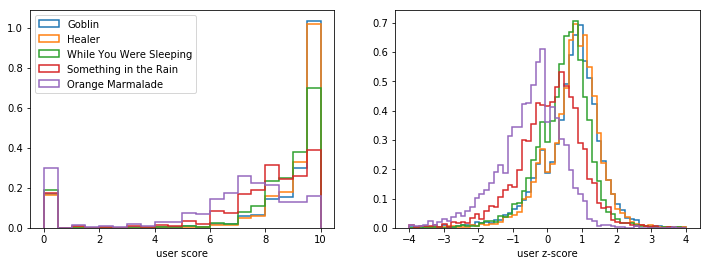

In [301]:
# df = df_shows.query("kind=='Drama' and completed and num_users>100 and user_score_count>5 and user_score_mean>0")
df_kdrama = df_shows.query("kind=='Drama' and country=='South Korea' and completed and num_users>100 and user_score_count>2 and user_score_mean>0")

print df_kdrama.shape


# df = df.groupby("title").get_group("W")
# df = df.groupby("title").get_group("Healer")
gb = df_kdrama.groupby("title")
# df = gb.get_group("Goblin")
# df = df.groupby("title").get_group("Love O2O")
# df = df.groupby("title").get_group("Descendants of the Sun")
# df = df.groupby("title").get_group("Bel Ami")
# df = df.groupby("title").get_group("Orange Marmalade")
# df = df.groupby("title").get_group("While You Were Sleeping")
# df = df.groupby("title").get_group("Something in the Rain")
# df = df.groupby("title").get_group("Temperature of Love")
# df.user_score_count.hist(bins=np.linspace(0,200,200))

fig,(ax1,ax2) = plt.subplots(1,2,figsize=(12,4))
for title in ["Goblin","Healer","While You Were Sleeping","Something in the Rain","Orange Marmalade"]:
    df = gb.get_group(title)
    ax1.hist(df["score"], bins=np.linspace(0,10,21),label=title,density=True,histtype="step",lw=1.5)
    ax2.hist(df["user_score_z"], bins=np.linspace(-4,4,60),label=title,density=True,histtype="step",lw=1.5)
ax1.set_xlabel("user score")
ax2.set_xlabel("user z-score")
ax1.legend(loc="upper left")

# df_shows.drop_duplicates(["title"]).sort_values(["score_z"],ascending=False)

# fig,ax = plt.subplots()
# for title in ["Goblin","Healer","Something in the Rain", "Orange Marmalade"]:
#     df = gb.get_group(title)
#     ax.hist((df["score"]), bins=np.linspace(0,10,21),label=title,density=True,histtype="step")
# ax.legend(loc="upper left")


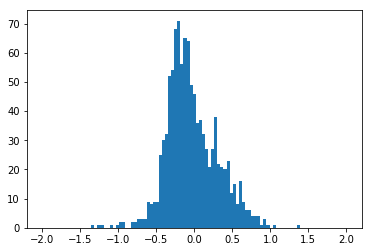

In [314]:
plt.hist(df_kdrama.groupby("title")["score_z"].first().values,bins=np.linspace(-2,2,100));

In [315]:
df_kdrama.groupby("tid")[["title","score_z"]].first().sort_values("score_z",ascending=False)

,title,score_z
tid,,
25172,My Mister,0.976995
22624,Prison Playbook,0.945062
13239,Signal,0.929821
30740,SKY Castle,0.917721
15845,Dear My Friends,0.877155
23920,Mr. Sunshine,0.850934
14324,Six Flying Dragons,0.829241
10814,Healer,0.807206
10619,Incomplete Life,0.805912


In [303]:
print df_users.memory_usage(deep=True).values.sum()/1e9
print df_shows.memory_usage(deep=True).values.sum()/1e9

0.013979099
0.519721075


In [37]:
df_shows

,completed,country,ep_seen,ep_total,kind,score,tid,title,year,uid,num_users,score_mean,score_median,user_score_mean
0,False,Japan,5,10,Drama,5.0,296,Abarenbo Mama,2007,3530,37,1.878378,0.0,2.722222
1,False,Japan,1,11,Drama,5.0,185,Celeb to Binbo Taro,2008,3530,55,2.190909,0.0,2.722222
2,False,South Korea,0,16,Drama,0.0,1701,Dream High 2,2012,3530,641,2.271451,1.0,2.722222
3,False,Japan,3,10,Drama,5.0,23,Kimi wa Petto,2003,3530,178,2.078652,0.0,2.722222
4,False,South Korea,2,16,Drama,3.5,31,My Girlfriend is a Gumiho,2010,3530,646,2.133901,0.0,2.722222
5,False,Japan,2,9,Drama,0.0,143,Q10,2010,3530,143,2.027972,0.0,2.722222
6,False,Japan,2,10,Drama,0.0,614,Shokojo Seira,2009,3530,57,1.903509,0.0,2.722222
7,False,Japan,2,11,Drama,0.0,16,Smile,2009,3530,91,2.230769,0.0,2.722222
8,False,South Korea,3,22,Drama,6.0,3686,Time Slip Dr. Jin,2012,3530,475,2.209474,0.0,2.722222
9,True,Japan,22,22,Drama,8.0,186,0 Goshitsu no Kyaku,2009,3530,115,5.152174,6.5,7.384181


100%|██████████| 42/42 [00:01<00:00, 39.16it/s]


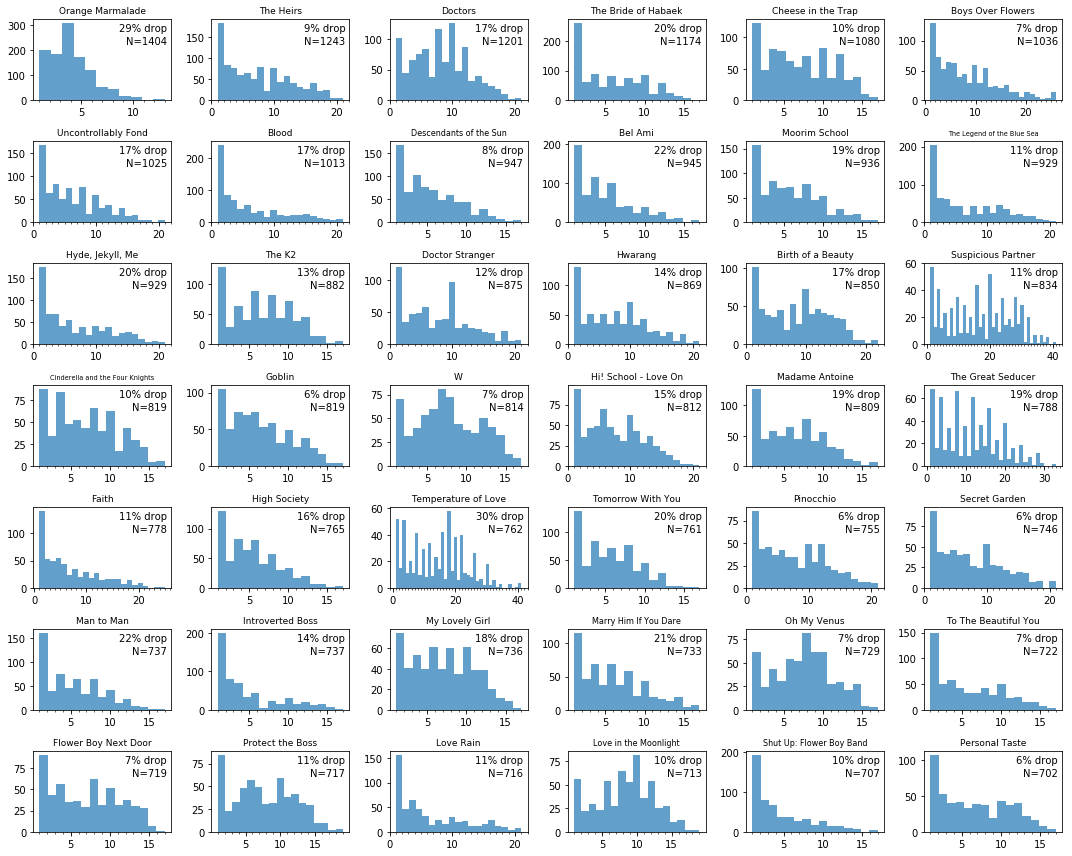

In [40]:
%matplotlib inline

df_compfrac = df_shows.groupby("title").aggregate("completed").mean()
d_compfrac = dict(df_compfrac.items())

df_drop = df_shows[~df_shows.completed]
drop_vc = df_drop.title.value_counts()
# drop_vc = ratios[ratios<1.].sort_values(ascending=False)
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator

# TODO right now this is plotting the top 49 most dropped shows
# try also plotting drop data for the top 49 most popular shows
# or actually top 49 shows with the highest drop rate (~drop count / complete count)

def get_fontsize(name):
    if len(name)>25: return 6.5
    if len(name)>20: return 8
    return 9


Nx = 6
Ny = 7
# N = 64
# N = 16
# print drop_vc[:50]
# fig,axs = plt.subplots(int(N**0.5),int(N**0.5),figsize=(15,12))
fig,axs = plt.subplots(Ny,Nx,figsize=(15,12))
gb = df_drop.groupby("title")
for ax,name in tqdm(zip(axs.flat,drop_vc[:Nx*Ny].keys().values)):
    es = gb.get_group(name).ep_seen
    et = gb.get_group(name).ep_total
    ax.hist(es,bins=np.linspace(1,et.max()+1,et.max()),alpha=0.7)
    ax.set_title(name,fontsize=get_fontsize(name))
    ax.text(0.97,0.95, "{:.0f}% drop".format(100.*(1.-d_compfrac[name])), ha='right', va='top', transform=ax.transAxes)
    ax.text(0.97,0.79, "N={}".format(len(es)), ha='right', va='top', transform=ax.transAxes)
#     ax.set_title("test")
    ax.xaxis.set_minor_locator(MultipleLocator(1.))
fig.set_tight_layout(True)
